In [1]:
import csv
import json

import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification

import torch

# from tqdm import tqdm
# import os
# import evaluate
# from datasets import load_dataset
# from collections import Counter, defaultdict

# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
with open("all.jsonl", 'r') as jsonl_file:
    jsonl_data = jsonl_file.read()
    json_lines = [
        json_line for json_line in jsonl_data.splitlines() if json_line.strip()]
    jsons_objs = [json.loads(json_line) for json_line in json_lines]
    jsons_objs_expand = []
    for i, obj in enumerate(jsons_objs):
        for human_answer in obj['human_answers']:
            jsons_objs_expand.append(
                {'question_id': i, 'text': human_answer, 'label': 0})
        for chatgpt_answer in obj['chatgpt_answers']:
            jsons_objs_expand.append(
                {'question_id': i, 'text': chatgpt_answer, 'label': 1})

In [3]:
with open("all.csv", "w") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([key for key in jsons_objs_expand[0].keys()])
    writer.writerows([json_obj.values() for json_obj in jsons_objs_expand])

In [4]:
with open('id_to_question.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'question'])
    for i, obj in enumerate(jsons_objs):
        writer.writerow([i, obj['question']])

In [5]:
all_df = pd.read_csv("all.csv")
all_df.dropna(inplace=True)
all_df.head()

,question_id,text,label
0,0,"Basically there are many categories of "" Best ...",0
1,0,"If you 're hearing about it , it 's because it...",0
2,0,"One reason is lots of catagories . However , h...",0
3,0,There are many different best seller lists tha...,1
4,1,salt is good for not dying in car crashes and ...,0


In [6]:
train_df, dev_df = train_test_split(all_df, test_size=0.2, random_state=42)
train_df.shape, dev_df.shape

((68344, 3), (17087, 3))

### Data Augumentation

In [7]:
aug_dev_df = dev_df.copy()

In [42]:
begin_with = [
    "I find that",
    "One can find that",
    "Maybe you can find that",
    "Hmmm, I think that",
    "With my knowledge, I think that",
    "Hope this helps: ",
    "From my experience, I believe that",
    "As far as I know,",
    "It seems to me that",
    "I've heard that",
    "If I had to guess, I'd say that",
    "I'd like to suggest that",
    "In my opinion,",
    "It's possible that",
    "I'm inclined to think that",
    "After careful consideration, I've concluded that",
    "Perhaps it's worth considering that",
    "I've noticed that",
    "Based on my understanding,",
    "It's my belief that",
    "If you ask me,",
    "Personally, I feel that",
    "In my humble opinion,",
    "Emmm,"
]

In [43]:
import random
new_text = []
for text in aug_dev_df['text']:
    idx = random.randint(0, len(begin_with) - 1)
    new_text.append(begin_with[idx] + ' ' + text)

In [44]:
aug_dev_df['text'] = new_text 

In [45]:
aug_dev_df.head()

,question_id,text,label
28148,7037,"I'm inclined to think that Maybe you can find that Eggs shrink as they develop . Even if they 're not fertile they still shrink as water slowly evaporates . Bird eggs have both a leathery shell ( mostly collagen ) and a hard shell ( mineralized with chalk ) . The leathery shell membrane peels back from the chalky outer shell , and that 's what makes the bubble . Technically it 's called the air cell . By the time a chick is ready to hatch , it 's absorbing oxygen through an umbilicus ( like mammal babies ) that attaches to blood vessels on the inside of the shell . For it to hatch it has to switch to using its lungs , and stop that umbilical blood flow . So it breaks the air cell ( which has gotten large by this point ) and breathes that air ( also through the outer shell ) . Once it has the strength to hatch , the chick breaks the outer shell too .",0
41039,10310,"Hmmm, I think that I'd like to suggest that 1 . People think insects are gross , and we do n't want to eat things that we think are gross . 2 . A lot of people do n't like seeing the fact that their food is an animal . Eating things with the head still on it , or eating things that are recognizably body parts , tends to turn people off . Because bugs are so small , it 's hard to make food out of them without just eating the whole thing and recognizing that you 're sticking a bug in your mouth .",0
51456,12977,"I find that I'd like to suggest that It's important to note that the number of visitors to a website does not necessarily correspond to the number of posts that are made on the site. A visitor is someone who simply visits the website, while a post is a piece of content that is created and shared by a user on the site. Reddit is a very popular website, with over 4 billion visitors per year. This means that a lot of people are visiting the site and looking at the content that is shared there. However, not all of these visitors are necessarily creating new posts or contributing to the site in other ways. Additionally, it's worth noting that not all posts on Reddit are created equal. Some posts are more popular and receive more attention from users, while others may not be as widely viewed or discussed. This is true of any website or social media platform, where some content tends to be more popular than others. So to sum it up, the number of visitors to a website like Reddit does not necessarily have anything to do with the number of posts that are made on the site. Different posts can receive different levels of attention and engagement, regardless of the overall popularity of the site.",1
29721,7430,"Maybe you can find that In my humble opinion, It should n't be any slower than swiping , but I believe your still working out some kinks in the US . You have n't had them for very long , have you ?",0
60715,15292,"Based on my understanding, Hope this helps: I ca n't speak for genetics , but I am certain that one factor is the track - and - field centered culture . Take the US for example . A kid who discovers that he is a little stronger and faster than the other kids in playground , may decide that sports is his calling . But which sport ? So many choices ... He has football , soccer , swimming , baseball , lacrosse ... you get the idea . More than likely he is going to settle on one of the more popular sports such as football , because of the prestige and money ( when was the last time ESPN paid attention to college track and field the way they pay attention to football ? ) In Jamaica , there is n't much infrastructure for many sports . Pretty much the only popular sports are ones that have minimal infrastructure . There is cricket , which was a popular sport since the days of British rule , soccer , because you just need a ball and a field , and track and field . ( Trivia : Usain Bolt was going to focus on cricket in high school , before his coach realized that he was pretty quick on his feet and should also look into track an

In [46]:
aug_dev_df.to_csv("all_aug_dev.csv")

In [13]:
with open("all_train.csv", "w") as csv_file:
    csv_file.write(train_df.to_csv(index=False))
with open("all_dev.csv", "w") as csv_file:
    csv_file.write(dev_df.to_csv(index=False))

In [14]:
all_dataset = load_dataset('csv', data_files={'train': 'all_train.csv', 'dev': 'all_dev.csv'})
all_dataset = all_dataset.remove_columns(["question_id"])
all_dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/hyfrankl/.cache/huggingface/datasets/csv/default-601c25cd4de379c1/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 68344
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 17087
    })
})

In [47]:
aug_dataset = load_dataset('csv', data_files={'train':"all_aug_dev.csv"})
aug_dataset = aug_dataset.remove_columns(["question_id"])
aug_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/hyfrankl/.cache/huggingface/datasets/csv/default-f848414289ed8a10/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label'],
        num_rows: 17087
    })
})

# Dummy classifiers

In [16]:
mf_dummy_clf = DummyClassifier(strategy="most_frequent")
mf_dummy_clf.fit(train_df.text, train_df.label)
mf_dummy_test_preds = mf_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, mf_dummy_test_preds, average='binary')

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

In [17]:
random_dummy_clf = DummyClassifier(strategy="stratified")
random_dummy_clf.fit(train_df.text, train_df.label)
random_dummy_test_preds = random_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, random_dummy_test_preds, average='binary')

(0.32088192419825073, 0.33195098963242226, 0.3263226165107014, None)

In [18]:
random_dummy_aug_preds = random_dummy_clf.predict(aug_dev_df.text)
precision_recall_fscore_support(aug_dev_df.label, random_dummy_aug_preds, average='binary')

(0.31224640354112876, 0.3191328934967012, 0.3156520928498182, None)

In [19]:
fpr_2, tpr_2, threshold = roc_curve(np.array(dev_df.label), random_dummy_test_preds)
auc(fpr_2, tpr_2)

0.5078104973624681

In [48]:
fpr_2_aug, tpr_2_aug, threshold = roc_curve(np.array(aug_dev_df.label), random_dummy_aug_preds)
auc(fpr_2_aug, tpr_2_aug)

0.5013165740612008

# Standard sklearn classifier(s)

In [21]:
# Convert text to features using a simple tf-idf
# min_df = is the minimum occurrences for a word to a feature
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df.text.values.astype('U'))

# Train a Logisitic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, train_df.label)

# Test the classifier by converting test data to features
X_test = vectorizer.transform(dev_df.text.values.astype('U'))
y_pred = clf.predict(X_test)
y_true = dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')


(0.9534516765285996, 0.9112158341187558, 0.9318554216867471, None)

In [22]:
pred_df = pd.DataFrame({'text': dev_df.text, 'label': dev_df.label, 'predict': y_pred})
pd.set_option('display.max_colwidth', None)
not_match_df = pred_df[pred_df.label != pred_df.predict]
not_match_df

,text,label,predict
72043,"YouTube is a video sharing platform that is owned by Google. Google is a multinational technology company that specializes in internet-related services and products, which include online advertising technologies, search engine, cloud computing, software, and hardware. Google was founded in 1998 by Larry Page and Sergey Brin while they were students at Stanford University. It has since grown into one of the largest and most influential companies in the tech industry.",1,0
71171,"New Hampshire is a state in the northeastern region of the United States. It is divided into 10 counties, each of which is further divided into towns. As of 2021, there are a total of 221 towns in New Hampshire.",1,0
16446,"MTV had lot of success with the original Real World , and began switching their formatting over to cheap , easy to produce , and popular reality television throughout the nineties . When online video became popular , it quickly took over the distribution of music videos , and signaled the end of music television",0,1
57007,"The transistors in every computer chip generate heat when they are in use . When the chips in your phone are processing data they are drawing the electricity in your phones battery and using it to switch the transistors , and heat is a byproduct . The more the chip works the more heat is generated .",0,1
72549,"Before the United States, Alaska was controlled by Russia. Russia established a presence in Alaska in the late 18th century and officially claimed the territory as Russian America in 1867. The United States purchased Alaska from Russia in 1867, in a transaction known as the ""Alaska Purchase."" The United States has controlled Alaska since that time.",1,0
...,...,...,...
57524,"Eating a whole pint of ice cream in one sitting is not necessarily worse than eating it over the course of the day. It really depends on your overall diet and how much ice cream you normally eat. If you rarely eat ice cream and only eat a small amount at a time, then eating a whole pint in one sitting may not be a problem. However, if you eat a lot of ice cream or have a diet that is high in sugar and fat, then eating a whole pint in one sitting could be unhealthy. It's important to remember that it's okay to treat yourself and have things like ice cream in moderation. It's when we eat large amounts of unhealthy foods on a regular basis that it can become a problem for our health. It's important to try to eat a balanced diet that includes a variety of healthy foods, and to not eat too much of any one food.",1,0
55924,"When you immerse your body in 81 degree Fahrenheit water, your body loses heat faster than it does when you are in 81 degree Fahrenheit air. This is because water is a better conductor of heat than air. When you are in the water, the heat from your body is conducted away by the water and your body cools down more quickly. When you are in the air, the heat from your body is not conducted away as efficiently and so you do not lose heat as quickly. That's why 81 degree Fahrenheit water feels colder than 81 degree Fahrenheit air. Does that make sense?",1,0
78542,"FHA (Federal Housing Administration) mortgages are a type of home loan that is insured by the Federal Housing Administration, a government agency. FHA loans are often attractive to first-time homebuyers and those with less-than-perfect credit, because they have more lenient credit and income requirements than conventional mortgages.Private mortgage insurance (PMI) is a type of insurance that is typically required by lenders when a borrower makes a down payment of less than 20% of the purchase price of a home. PMI protects the lender in the event that the borrower defaults on the mortgage.FHA loans do require the borrower to pay for mortgage insurance, but this insurance is different from PMI. FHA mortgage insurance is called mortgage insurance premium (MIP) and is required for all FHA loans. MIP is similar to PMI in that it protects the l

In [23]:
fpr_3, tpr_3, threshold = roc_curve(np.array(y_true), y_pred)
auc(fpr_3, tpr_3)

0.9455926395173646

In [49]:
aug_X_test = vectorizer.transform(aug_dev_df.text.values.astype('U'))
aug_y_pred = clf.predict(aug_X_test)
aug_y_true = aug_dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(aug_y_true, aug_y_pred, average='binary')

fpr_sk, tpr_sk, threshold = roc_curve(np.array(aug_y_true),aug_y_pred)
auc(fpr_sk, tpr_sk)

0.9318991525435931

# Fancy Huggingface classifiers

We'll use [MiniLM](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased) which is a compressed version of a BERT-like model that is faster to train

In [25]:
torch.cuda.is_available()

True

In [26]:
# Verify there's at least one GPU sitting around (or not if you want to try CPU!)
torch.cuda.device_count()

1

In [27]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 68344
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 17087
    })
})

### Prepare the text

We need to tokenize the data. Each large language model (LLM) has its own tokenizer, so we will have to specify how the model expects the text to be turned into tokens. In huggingface, we'll specify a LLM using a string name, e.g., "microsoft/MiniLM-L12-H384-uncased" for MiniLM. You can see more details on different possible model on Huggingface's [model repo](https://huggingface.co/models)

In [28]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_all = all_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/68344 [00:00<?, ? examples/s]

Map:   0%|          | 0/17087 [00:00<?, ? examples/s]

### Train the model

In [29]:
# Huggingface will generate model checkpoints and these can
# take up a lot of space, so be sure to set this directory somewhere where
# you can check

output_dir = '.'

# This code block is used so we can have a deterministic training procedure
# (i.e., get the same result each time)
model_name = "microsoft/MiniLM-L12-H384-uncased"


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=8e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    do_eval=True,
    seed=1234,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    logging_dir=output_dir + 'logs/',
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_all["train"],
    eval_dataset=tokenized_all["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hyfrankl/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that wi

Epoch,Training Loss,Validation Loss
1,0.204000,0.210207


TrainOutput(global_step=8543, training_loss=0.2204715601945529, metrics={'train_runtime': 840.9734, 'train_samples_per_second': 81.268, 'train_steps_per_second': 10.158, 'total_flos': 3140747957532864.0, 'train_loss': 0.2204715601945529, 'epoch': 1.0})

In [30]:
trainer.evaluate()

{'eval_loss': 0.21020738780498505,
 'eval_runtime': 48.1923,
 'eval_samples_per_second': 354.559,
 'eval_steps_per_second': 44.322,
 'epoch': 1.0}

In [31]:
dev_logits = trainer.predict(tokenized_all["dev"])
print(dev_logits.predictions.shape, dev_logits.label_ids.shape)
dev_preds = np.argmax(dev_logits.predictions, axis=-1)
precision_recall_fscore_support(dev_df.label, dev_preds, average='binary')

(17087, 2) (17087,)


(0.9847696879643388, 0.9994344957587182, 0.9920478997099823, None)

In [ ]:
tokenized_aug = aug_dataset.map(preprocess_function, batched=True)

aug_dev_logits = trainer.predict(tokenized_aug["train"])
print(aug_dev_logits.predictions.shape, aug_dev_logits.label_ids.shape)
aug_dev_preds = np.argmax(aug_dev_logits.predictions, axis=-1)
fpr_aug, tpr_aug, threshold = roc_curve(np.array(aug_dev_df.label), aug_dev_preds)
auc(fpr_aug, tpr_aug)

Map:   0%|          | 0/17087 [00:00<?, ? examples/s]

In [35]:
fpr, tpr, threshold = roc_curve(np.array(dev_df.label), dev_preds)
auc(fpr, tpr)

0.9962373633096766

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

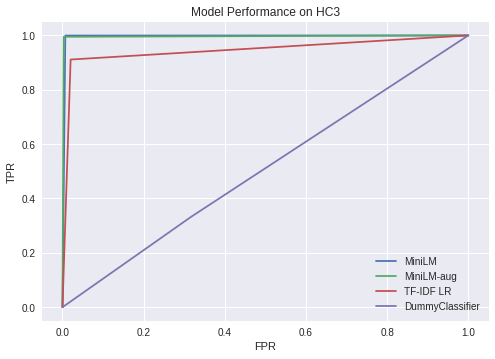

In [41]:
plt.style.use("seaborn")
plt.plot(fpr, tpr)
plt.plot(fpr_aug, tpr_aug)
plt.plot(fpr_3, tpr_3)
plt.plot(fpr_2, tpr_2)
plt.legend(['MiniLM', 'MiniLM-aug', 'TF-IDF LR', 'DummyClassifier'])
plt.title("Model Performance on HC3")
plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.xscale('log')
# plt.yscale('log')
plt.savefig("res")